In [45]:
import numpy as np
import glob
import os
import pandas as pd
from common.bio.constants import ID_TO_AMINO_ACID
from tqdm import tqdm

## Reading results from file

In [74]:
ROOT="../../../bert/weights/sample/eval_results/"
list_of_files = glob.glob(ROOT+ "*.npy") # * means all if need specific format then *.csv
latest_file = max(list_of_files, key=os.path.getctime)
#latest_file
latest_file = "../../../bert/weights/sample/eval_results/20181128-081345.npy"

In [75]:
f = open(latest_file, 'rb')

In [76]:
results = None
while True:
    try:
        if results is None:
            results = np.load(f)
        else:
            extra_results = np.load(f)
            for i in range(7):
                results[i] = np.append(results[i],extra_results[i], axis=0)
    except OSError as e:
        print("END of file")
        break
    except Exception as e:
        print(e)
        break
f.close()

END of file


In [77]:
results.shape

(7,)

In [78]:
input_ids, input_mask, masked_lm_positions, masked_lm_ids, masked_lm_weights,masked_lm_example_loss, masked_lm_log_probs = results

## Preprocessing

In [79]:
masked_lm_log_probs_reshape = np.reshape(masked_lm_log_probs, (-1,20,22))

In [80]:
predictions = np.argmax(masked_lm_log_probs_reshape, axis=2)

In [81]:
accuracy = np.mean(masked_lm_ids == predictions, axis=1)
np.mean(accuracy)

0.41503124999999996

## Analysis

In [82]:
np.count_nonzero(np.where(accuracy ==0.15)[0])

459

In [83]:
np.unique(accuracy, return_counts=True)


(array([0.  , 0.05, 0.1 , 0.15, 0.2 , 0.25, 0.3 , 0.35, 0.4 , 0.45, 0.5 ,
        0.55, 0.6 , 0.65, 0.7 , 0.75, 0.8 , 0.85, 0.9 , 0.95, 1.  ]),
 array([ 56, 193, 360, 459, 518, 487, 507, 471, 476, 471, 415, 357, 319,
        283, 261, 226, 203, 148,  89,  73,  28], dtype=int64))

In [65]:
unique, counts = np.unique(predictions, return_counts=True)
dict(zip(unique, counts))

{1: 11883,
 2: 710,
 3: 4255,
 4: 10916,
 5: 1058,
 6: 10674,
 7: 530,
 8: 3963,
 9: 10575,
 10: 35481,
 11: 1164,
 12: 1599,
 13: 5594,
 14: 911,
 15: 7291,
 16: 9639,
 17: 3057,
 18: 7220,
 19: 251,
 20: 1229}

In [66]:
worst = np.argmin(accuracy)
best = np.argmax(accuracy)
accuracy[worst], accuracy[best]

(0.0, 1.0)

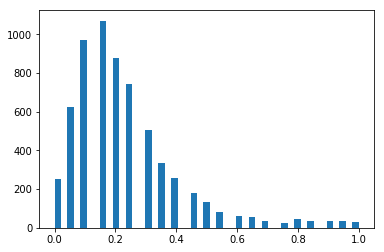

In [67]:
import matplotlib.pyplot as plt
plt.hist(accuracy, bins='auto')
plt.show()

In [68]:
def get_table(index):
    print("Accuracy:{}".format(accuracy[index]))
    in_seq, original = "", ""
    mask_count = 0
    for i, a in enumerate(input_ids[index]):
        if a == 0:
            break
        if a == 21:
            position = np.argwhere(masked_lm_positions[index] == i)[0][0]
            in_seq = in_seq + "("+ID_TO_AMINO_ACID[predictions[index][position]]+")"
            original = original + "("+ID_TO_AMINO_ACID[masked_lm_ids[index][position]]+")"
            mask_count+=1
        else:
            in_seq = in_seq + ID_TO_AMINO_ACID[a]
            original = original + ID_TO_AMINO_ACID[a]

    print(in_seq) 
    print(original)
    #assert mask_count == 20
    data = list(zip(masked_lm_ids[index],predictions[index], masked_lm_log_probs_reshape[index].max(axis=1), 
                    masked_lm_log_probs_reshape[index].argsort(axis=1)[:, ::-1],
                    np.sort(masked_lm_log_probs_reshape[index])[:, ::-1]))
    df = pd.DataFrame(data, columns=['Correct', 'Guess', 'Probability', 'Other guess', 'Probs'], index=masked_lm_positions[index]) 
    return df.sort_index()

In [70]:
get_table(100)

Accuracy:0.2
(M)TTLFHLPHN(L)LLH(L)HESFLKSKLTKVQGLGYSGP(S)IPS(S)GLSSACAQSLTN(L)HGNRAK(R)KLVSVRVASDDTGNRSDDENSDRD(S)ASQSEND(S)VPGP(L)S(L)E(E)LER(L)VGQDDSTFSGV(E)LATLIRKKYGRSYDVQLIKKEFMGRNLLAMNVMWKYMEQRS(L)PLTEDEY(L)LRLDDVANTLKCWGAVS(S)VRNSLAK(L)RERP(L)IGKVFL
(M)TTLFHLPHN(F)LLH(G)HESFLKSKLTKVQGLGYSGP(Q)IPS(G)GLSSACAQSLTN(L)HGNRAK(L)KLVSVRVASDDTGNRSDDENSDRD(E)ASQSEND(E)VPGP(L)S(R)E(D)LER(I)VGQDDSTFSGV(D)LATLIRKKYGRSYDVQLIKKEFMGRNLLAMNVMWKYMEQRS(F)PLTEDEY(I)LRLDDVANTLKCWGAVS(H)VRNSLAK(L)RERP(R)IGKVFL


,Correct,Guess,Probability,Other guess,Probs
0,11,11,-0.677958,"[11, 10, 16, 17, 1, 18, 13, 8, 6, 5, 15, 4, 9,...","[-0.6779584, -2.8122869, -3.170254, -3.4526722..."
10,5,10,-2.193849,"[10, 16, 13, 17, 18, 8, 1, 12, 4, 14, 3, 15, 9...","[-2.1938486, -2.2787352, -2.4806004, -2.537980..."
14,6,10,-2.216154,"[10, 16, 17, 13, 4, 3, 9, 15, 18, 12, 1, 8, 14...","[-2.2161539, -2.2405763, -2.7166219, -2.757895..."
35,14,16,-2.125419,"[16, 10, 6, 13, 18, 15, 1, 17, 4, 9, 14, 3, 12...","[-2.125419, -2.4301233, -2.5485756, -2.6191194..."
39,6,16,-2.004385,"[16, 10, 13, 17, 1, 6, 15, 18, 4, 9, 14, 12, 3...","[-2.0043845, -2.3130312, -2.3931456, -2.764888..."
39,6,16,-2.004385,"[16, 10, 13, 17, 1, 6, 15, 18, 4, 9, 14, 12, 3...","[-2.0043845, -2.3130312, -2.3931456, -2.764888..."
52,10,10,-2.168474,"[10, 16, 18, 6, 17, 13, 15, 1, 8, 9, 12, 4, 5,...","[-2.1684737, -2.1752949, -2.7353945, -2.761966..."
59,10,15,-1.838424,"[15, 9, 16, 13, 1, 6, 10, 4, 18, 17, 14, 12, 3...","[-1.8384237, -2.1531982, -2.3729224, -2.620595..."
84,4,16,-1.772578,"[16, 4, 3, 6, 1, 17, 13, 10, 15, 12, 18, 14, 9...","[-1.7725775, -2.3862848, -2.405793, -2.5428982..."
92,4,16,-2.098116,"[16, 4, 3, 13, 1, 6, 17, 10, 18, 15, 12, 14, 9...","[-2.0981162, -2.331119, -2.3791833, -2.625118,..."


In [71]:
def for_analysis(index):
    guessed, original = "", ""
    mask_count = 0
    for i, a in enumerate(input_ids[index]):
        if a == 0:
            break
        if a == 21:
            position = np.argwhere(masked_lm_positions[index] == i)[0][0]
            guessed = guessed + "("+ID_TO_AMINO_ACID[predictions[index][position]]+")"
            original = original + "("+ID_TO_AMINO_ACID[masked_lm_ids[index][position]]+")"
            mask_count+=1
        else:
            guessed = guessed + ID_TO_AMINO_ACID[a]
            original = original + ID_TO_AMINO_ACID[a]
    data = list(zip(masked_lm_ids[index],predictions[index], masked_lm_log_probs_reshape[index].max(axis=1), 
                    masked_lm_log_probs_reshape[index].argsort(axis=1)[:, ::-1],
                    np.sort(masked_lm_log_probs_reshape[index])[:, ::-1].tolist()))
    df = pd.DataFrame(data, columns=['Correct', 'Guess', 'Probability', 'Other guess', 'Probs'], index=masked_lm_positions[index]) 
    df["Correct"] = df["Correct"].apply(lambda x: ID_TO_AMINO_ACID[x])
    df["Guess"] = df["Guess"].apply(lambda x: ID_TO_AMINO_ACID[x])
    df["Other guess"] = df["Other guess"].apply(lambda x: [ID_TO_AMINO_ACID.get(e,".") for e in x])
    return df.sort_index(), original, guessed

In [73]:
t, _,_ = for_analysis(100)
t

,Correct,Guess,Probability,Other guess,Probs
0,M,M,-0.677958,"[M, L, S, T, A, V, P, I, G, F, R, E, K, Q, N, ...","[-0.6779584288597107, -2.812286853790283, -3.1..."
10,F,L,-2.193849,"[L, S, P, T, V, I, A, N, E, Q, D, R, K, F, G, ...","[-2.1938486099243164, -2.2787351608276367, -2...."
14,G,L,-2.216154,"[L, S, T, P, E, D, K, R, V, N, A, I, Q, G, F, ...","[-2.216153860092163, -2.2405762672424316, -2.7..."
35,Q,S,-2.125419,"[S, L, G, P, V, R, A, T, E, K, Q, D, N, I, F, ...","[-2.1254189014434814, -2.4301233291625977, -2...."
39,G,S,-2.004385,"[S, L, P, T, A, G, R, V, E, K, Q, N, D, I, H, ...","[-2.0043845176696777, -2.3130311965942383, -2...."
39,G,S,-2.004385,"[S, L, P, T, A, G, R, V, E, K, Q, N, D, I, H, ...","[-2.0043845176696777, -2.3130311965942383, -2...."
52,L,L,-2.168474,"[L, S, V, G, T, P, R, A, I, K, N, E, F, Q, D, ...","[-2.168473720550537, -2.175294876098633, -2.73..."
59,L,R,-1.838424,"[R, K, S, P, A, G, L, E, V, T, Q, N, D, I, H, ...","[-1.838423728942871, -2.1531982421875, -2.3729..."
84,E,S,-1.772578,"[S, E, D, G, A, T, P, L, R, N, V, Q, K, H, I, ...","[-1.7725775241851807, -2.386284828186035, -2.4..."
92,E,S,-2.098116,"[S, E, D, P, A, G, T, L, V, R, N, Q, K, I, H, ...","[-2.098116159439087, -2.3311190605163574, -2.3..."


In [27]:
filename = latest_file.split("\\")[-1].split(".")[0]
file_path = os.path.join(ROOT, filename+".tsv")
print("Saving to {}".format(file_path))
with open(file_path, 'w') as file:
    for p in tqdm(range(len(predictions))):
        df, original, guessed =for_analysis(p)
        file.write("Original sequence: {}\n".format(original))
        file.write("Recreated sequnce: {}\n".format(guessed))
        df.to_csv(file, sep="\t")

Saving to ../../../bert/weights/sample/eval_results/20181126-082328.tsv


100%|██████████| 6400/6400 [00:54<00:00, 117.49it/s]


In [30]:
df, o, g = for_analysis(98)

In [31]:
o

'MPSRQSPATSRTP(T)LATQSPTLPRSQGRSTSRGSS(A)S(S)RSVAAARSRSV(R)AEPTRSRAASSPRSSRAHLQSMLEILE(D)REEARLEELNRYSDEVDVNN(T)EQTSTCPI(F)DGIYRDGGAEAVLRLTNFAPSEINTLWFSVRG(H)VHRYW(N)VGRGRR(S)TFAAK(D)VFFMLLVVMKCGGTWDMVAR(I)(F)KVKTPTFIKTITGFIEVVTRK(L)YEEWVTSQLDVTT(M)RALVTSGHTFNNFPCALYATDV(T)FQQSNRPSGSMAEAMPFYSAKHKFEIGSDLSE(A)ESDT(T)QMPR'

In [32]:
g

'MPSRQSPATSRTP(S)LATQSPTLPRSQGRSTSRGSS(R)S(S)RSVAAARSRSV(S)AEPTRSRAASSPRSSRAHLQSMLEILE(E)REEARLEELNRYSDEVDVNN(L)EQTSTCPI(C)DGIYRDGGAEAVLRLTNFAPSEINTLWFSVRG(L)VHRYW(R)VGRGRR(L)TFAAK(A)VFFMLLVVMKCGGTWDMVAR(R)(L)KVKTPTFIKTITGFIEVVTRK(E)YEEWVTSQLDVTT(L)RALVTSGHTFNNFPCALYATDV(L)FQQSNRPSGSMAEAMPFYSAKHKFEIGSDLSE(S)ESDT(S)QMPR'

In [33]:
df

,Correct,Guess,Probability,Other guess,Probs
13,T,S,-1.235765,"[S, R, T, A, P, G, V, L, Q, K, N, H, E, D, I, ...","[-1.235764503479004, -1.752168893814087, -2.09..."
13,T,S,-1.235765,"[S, R, T, A, P, G, V, L, Q, K, N, H, E, D, I, ...","[-1.235764503479004, -1.752168893814087, -2.09..."
35,A,R,-1.066971,"[R, S, A, P, T, G, V, L, Q, K, H, N, I, D, E, ...","[-1.0669714212417603, -1.9079922437667847, -2...."
37,S,S,-1.277377,"[S, R, P, A, T, G, V, L, K, Q, N, D, H, E, I, ...","[-1.2773770093917847, -1.699790596961975, -2.0..."
49,R,S,-0.980701,"[S, A, P, T, R, V, G, L, Q, D, E, K, N, I, H, ...","[-0.9807013273239136, -1.396433711051941, -2.5..."
77,D,E,-1.674379,"[E, A, R, Q, K, S, L, D, T, N, G, V, H, M, P, ...","[-1.6743786334991455, -1.7387208938598633, -1...."
98,T,L,-2.212174,"[L, P, V, A, D, I, S, G, E, T, F, R, Y, N, Q, ...","[-2.2121739387512207, -2.4130501747131348, -2...."
107,F,C,-1.356793,"[C, L, P, V, A, I, S, R, T, F, G, E, D, Y, K, ...","[-1.3567934036254883, -2.348167657852173, -2.5..."
107,F,C,-1.356793,"[C, L, P, V, A, I, S, R, T, F, G, E, D, Y, K, ...","[-1.3567934036254883, -2.348167657852173, -2.5..."
140,H,L,-2.319895,"[L, A, V, E, R, G, S, F, T, I, K, P, D, Y, Q, ...","[-2.319895029067993, -2.569725275039673, -2.62..."
